# ACCELERATING IMAGE GENERATION ON FPGA

----

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

In [2]:
import os
import time
import numpy as np
import vart 
from matplotlib import pyplot as plt
from datetime import datetime 
%matplotlib inline

In [3]:
overlay.load_model('./ganmodel.xmodel')

In [4]:
def compute_tanh(x): 
    return np.tanh(x) 

In [5]:
dpu = overlay.runner

In [6]:
dpu

vart::Runner@0xaaaaec677640

In [7]:
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)
print(shapeIn, shapeOut, outputSize)

(1, 8, 4, 4) (1, 32, 32, 1) 1024


In [8]:
def genImages(N=10):
    ret = [] 
    for i in range(N):
        output_data = [np.empty(shapeOut, dtype=np.float32, order="C")] 
        a = np.random.normal(0,1,shapeIn).astype(dtype = np.float32, order="C")
        input_data = [a]
        start = datetime.now() 
        job_id = dpu.execute_async(input_data, output_data)
        dpu.wait(job_id)
        print('Elapsed time for inference only:',datetime.now() - start)
        out = compute_tanh(output_data)
        print('Elapsed time for full image generation:',datetime.now() - start)
        ret.append(out)
    return ret 

In [9]:
imgs = genImages(100)
print(len(imgs)) 

Elapsed time for inference only: 0:00:00.003469
Elapsed time for full image generation: 0:00:00.005023
Elapsed time for inference only: 0:00:00.003082
Elapsed time for full image generation: 0:00:00.003373
Elapsed time for inference only: 0:00:00.002909
Elapsed time for full image generation: 0:00:00.003148
Elapsed time for inference only: 0:00:00.002914
Elapsed time for full image generation: 0:00:00.003159
Elapsed time for inference only: 0:00:00.002891
Elapsed time for full image generation: 0:00:00.003116
Elapsed time for inference only: 0:00:00.002891
Elapsed time for full image generation: 0:00:00.003097
Elapsed time for inference only: 0:00:00.002886
Elapsed time for full image generation: 0:00:00.003112
Elapsed time for inference only: 0:00:00.002887
Elapsed time for full image generation: 0:00:00.003128
Elapsed time for inference only: 0:00:00.002885
Elapsed time for full image generation: 0:00:00.003127
Elapsed time for inference only: 0:00:00.002885
Elapsed time for full ima

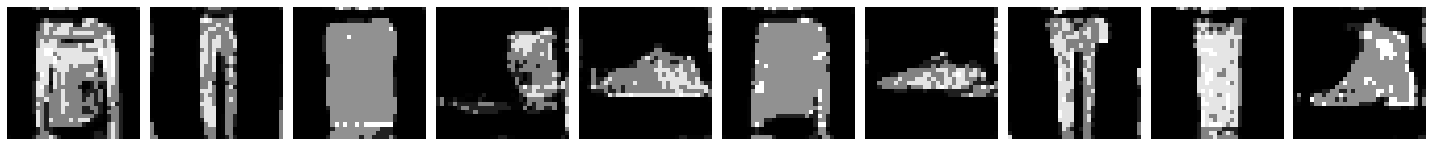

In [16]:
idxs = [np.random.randint(0, len(imgs)) for x in range(10)] 
y = [imgs[i] for i in idxs]

def plot(y): 
    num_img = len(y) 
    fig, axes = plt.subplots(1, num_img, figsize=(20,10))
    for i in range(num_img):
        #img = tfk.preprocessing.image.array_to_img(imgs[i])
        img = y[i] 
        ax = axes[i%num_img]
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot(y)

In [11]:
del dpu 
del overlay 